# Exercise 1 Modeling and analysis of spike trains

**Objective:** The goal of this exercise is to learn basic tools of spiking data analysis and to the explore the dynamics Leaky Integrate and Fire (LIF) neural model

**Components:** This exercise has three steps: first you must implement tools for data analysis and use them to analyse a spike train from the mouse retina. Second you must generate spikes with a neural simulator, brian. Third you should compare the experimental and simulated spike trains. For comparison you should use the tools developed in the first step.

**Code organization:** Several files are provided to you: exercise1.ipynb (the jupyter notebook); io_spiking_data.py; spiking_data_analysis.py; interface_simulator.py. 
In exercise1.ipynb you should write your written answers, but in terms of code there is very few things to change. It is already formated for the exercise. <!---On the top of this file are defined the model parameters, you should not change them, as they were set to mimic mouse cells. -->
You should not change io_spiking_data.py. If you do it, most probably you will have troubles reading and writting your data.
You should write text on exercise1.ipynb and code on the files spiking_data_analysis.py and interface_simulator.py.

## Part I: Experimental spike train analysis

Load the necessary packages, experimental data, and define global variables

In [1]:
# load packages
%load_ext autoreload
#this is to update your packages automatically
%autoreload 2
# more info https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html#autoreload

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import brian2 as b2
from neurodynex.leaky_integrate_and_fire import LIF
from neurodynex.tools import plot_tools, spike_tools
import time
import io_spike_train
import data_analysis
import interface_simulator

# do not change these parameters! These are standard values for the LIF model. They were estimated based on experimental data. For more informations see neural dynamics book.

V_REST = -70 #mV
V_RESET = -70 #mV #we assume that the resting potential is the same as the reset potential
FIRING_THRESHOLD = -50 #mV
MEMBRANE_RESISTANCE = 10.*10**(9) #mohm 
MEMBRANE_TIME_SCALE = 8. #(tau) ms
ABSOLUTE_REFRACTORY_PERIOD = 0.0#we didn't speak about this parameter in the class. For more informations see neural dynamics book. ms
t_max_constant_current = 1e3 #(ms)
t_max_varying_current = 1e4 #(ms)
t_start = 0
max_lag = 150

Please write the full path to the exercise folder

In [2]:
exercise_folder_path = '/Users/wangyu980312/Desktop/MI210/Cours1/Exercise1/' # This string must end with a slash ('/') 

Loading and plotting the data

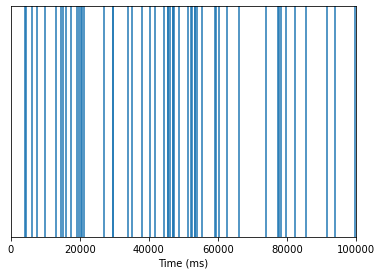

In [3]:
# first define the file_name and load the file
file_name_spike_train_experimental = exercise_folder_path + "experimental_spike_train.hdf5"
spike_train_experimental = io_spike_train.read_spike_train_H5(file_name_spike_train_experimental)

#then plot your data
data_analysis.plot_spike_train(spike_train_experimental)

<span style="color:blue"> **Question 1.** In 2 or 3 paragraphs define temporal sparseness and burst of activity of a spike train</span>

A1: 
Temporal sparseness is just spikes of activities but not directly related to the activity of the neuron. It is when the spikes are not really following each others. Bursts of activity are many spikes during a short interval of time.

<span style="color:green"> **Question 2.** In data_analysis.py write a functon to estimate the average spike rate of a spike train. The spike rate should come in Hz (spikes/sec). Use this function to estimate the spike rate of the experimental data</span>  

In [4]:
experimental_avg_spike_rate = data_analysis.get_average_spike_rate(spike_train_experimental)
print('The experimental data average spike rate is ' + str(experimental_avg_spike_rate) + 'Hz')

The experimental data average spike rate is 0.53Hz


<span style="color:green"> **Question 3.** In data_analysis.py write a functon to estimate the distribution of the inter-spike intervals of a spike train. Hint: start by estimating the all the time differences between consecutive spikes. Use this function to estimate the inter-spike interval of the experimental data. </span>  

In [5]:
experimental_isi = data_analysis.get_isi(spike_train_experimental)

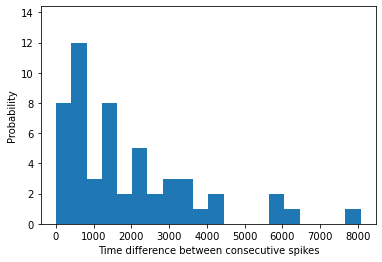

In [6]:
data_analysis.plot_isi(experimental_isi[0],experimental_isi[1])

<span style="color:green"> **Question 4**. In data_analysis.py write a functon to estimate the the autocorrelation of a spike train. Estimate the autocorrelation of the experimental spike train, please don't forget to change the maximum lag.</span>  

In [7]:
max_lag = 150 #introduce a value here!
experimental_auto_corr = data_analysis.get_autocorrelation(spike_train_experimental, max_lag)

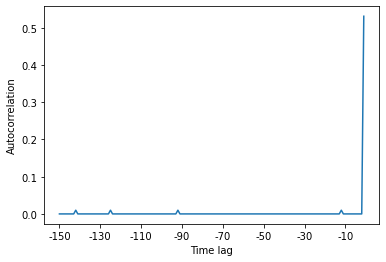

In [8]:
data_analysis.plot_autocorrelation(experimental_auto_corr,max_lag)

<span style="color:blue"> **Question 5.**Based on the three measures above, define a function in data_analysis that detects bursts of activity. Criticize this function defining its pros and cons. You can use a function already defined in the literature, just do not forget to include the bibliography in the report.</span> 

In [9]:
burst_interval = data_analysis.detect_burst(spike_train_experimental, 500)
print(burst_interval)

[[4000, 4750], [20250, 20750], [29250, 30000], [45250, 46000], [46750, 47500], [53000, 53500], [77250, 77750]]


This is a simple detection function, which outputs the interval of bursts of activity. Its advantage is that the method is very intuitive (in a given time interval, if the number of spikes exceeds a threshold, it is judged as an interval of bursts of activity), and it also allows users to customize the interval size to adapt to different data. But its shortcomings are also obvious, that is, the determination of the threshold, which is very sensitive to data, and it is difficult to find a universal threshold definition method.

## Part II: Leaky Integrate and Fire (LIF) neural model: dynamics and simulation

 For more information on the LIF neural model, you can consult the neuronal dynamics book available online at: https://neuronaldynamics.epfl.ch/

<span style="color:blue"> **Question 6.** In 2 or 3 paragraphs summarize the leak-Integrate and fire neuron model.</span> 

A6: LIF is a neuron model. For this type of neuron model, the input signal directly affects the state of the neuron (membrane potential), and only when the membrane potential rises to the threshold potential, an output pulse signal is generated.

<span style="color:green"> **Question 7.** Under this model, derive mathematically the dynamics of the membrane potential when there is no input current, thus I(t) = 0, assuming that at time t0 the V(t0)= Vrest+ δ, with 0<δ<τ, where τ is the membrane threshold. Interpret the result and make predictions in terms of spiking patterns.</span> 

A7: According to the title, we can get V(t) = δ*exp((t0-t)/τ)+Vrest  
When the current is 0, the voltage will gradually decrease to Vrest. Since the voltage never exceeds the membrane threshold Vth, there will be no spiking patterns.

<span style="color:green">**Question 8.**Under this model, derive mathematically the dynamics of the membrane potential when the input current is constant, thus I(t) = K, for some K>0, assuming that at V(t0) = Vrest. Calculate the minimal current for which there is spiking activity. Interpret and make predictions in terms of spiking patterns.</span>  

A8: According to the title, we can get V(t) = RK*(1-exp((t0-t)/τ))+Vrest and we can calculate the minimal current for which is a spiking activity is I(t) = K > (Vth-Vrest)/R.  
When the current is greater than 0, the voltage will gradually increase, but only when the value of the current K exceeds (Vth-Vrest)/R, the voltage will exceed the membrane threshold Vth and produce a spiking pattern.

<span style="color:green">**Question 9.**Under the same assumptions, estimate the period for the case when the input current is above the minimal current.</span> 

A9: When the input current is above the minimal current, we can calcute that the period T = -τ*log(1-(Vth-Vrest)/RK)

<span style="color:green"> **Question 10.** In the file “interface_simulator.py” write a function in python that given the LIF model parameters returns the minimal current for the neuron to spike. Choose the relevant variables for this function and calculate the minimal current for the model parameters defined in the beginning of the main.py file.</span> 

In [10]:
Imin = interface_simulator.get_Imin(V_RESET,FIRING_THRESHOLD, MEMBRANE_RESISTANCE )
print("The minimal current to spike is " + str(Imin) + "mA")

The minimal current to spike is 2e-09mA


<span style="color:green"> **Question 11.**Generate two constant input currents as defined in 7): one bellow the the minimal current, one above the minimal current. For both spike trains, you just have to change the value of the current and run the Brian simulator and analyse their membrane potential and the spiking patterns. Do they correspond to the theoretical expectations? [Note: for this simulator, the time to run is proportional to the time to generate spikes. It is normal to take minutes to finish]</span> 

nr of spikes: 0
Warning! The spike train has zero spikes!


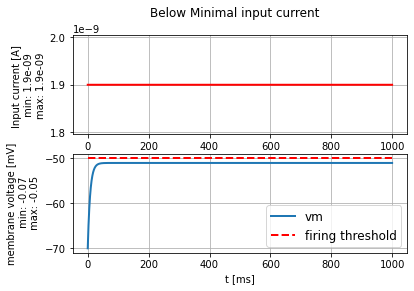

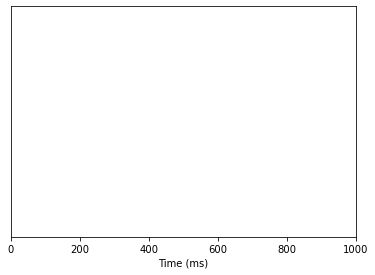

In [11]:
#####a) below

I_below = 1.9e-9 #introduce the value here!

I_below_array = interface_simulator.make_constant_array(t_start, t_max_constant_current, I_below) #defines the current as a numpy array
I_below_current =  io_spike_train.adapt_input(I_below_array) #converts the numpy array into a current that brian can read

#simulating the neuron
#NOTE: In the first time you run this simulator, it might raise a warning, just dismiss it!
(I_below_state_monitor, I_below_spike_monitor) = LIF.simulate_LIF_neuron(
        input_current = I_below_current, simulation_time = t_max_constant_current * b2.ms,v_rest = V_REST*b2.mV,v_reset = V_RESET*b2.mV, firing_threshold = FIRING_THRESHOLD*b2.mV, membrane_resistance = MEMBRANE_RESISTANCE * b2.mohm, membrane_time_scale = MEMBRANE_TIME_SCALE* b2.ms, abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD* b2.ms) 

#plotting
plt.figure()
plot_tools.plot_voltage_and_current_traces(
        I_below_state_monitor, I_below_current, title="Below Minimal input current", firing_threshold=FIRING_THRESHOLD*b2.mV)
print("nr of spikes: {}".format(I_below_spike_monitor.count[0])) #plots the current and voltage

I_below_spike_train = io_spike_train.extract_spike_train_from_spike_monitor(I_below_spike_monitor,t_max_constant_current) #converts the spikes from brian into a numpy array

data_analysis.plot_spike_train(I_below_spike_train) #plots the spike train

nr of spikes: 40


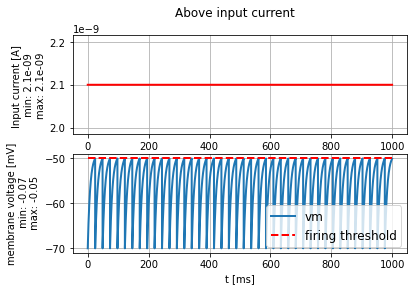

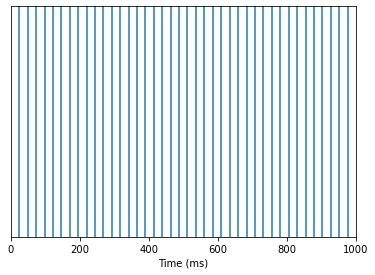

In [12]:
##### b)
I_above = 2.1e-9 #introduce the value here!

I_above_array = interface_simulator.make_constant_array(t_start, t_max_constant_current,I_above)
I_above_current = io_spike_train.adapt_input(I_above_array)

(I_above_state_monitor, I_above_spike_monitor) = LIF.simulate_LIF_neuron(
        input_current = I_above_current, simulation_time = t_max_constant_current * b2.ms,v_rest = V_REST*b2.mV,v_reset = V_RESET*b2.mV, firing_threshold = FIRING_THRESHOLD*b2.mV, membrane_resistance = MEMBRANE_RESISTANCE * b2.mohm, membrane_time_scale = MEMBRANE_TIME_SCALE* b2.ms, abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD* b2.ms)

plt.figure()
plot_tools.plot_voltage_and_current_traces(
        I_above_state_monitor,I_above_current, title = "Above input current", firing_threshold = FIRING_THRESHOLD*b2.mV)
print("nr of spikes: {}".format(I_above_spike_monitor.count[0]))

I_above_spike_train = io_spike_train.extract_spike_train_from_spike_monitor(I_above_spike_monitor, t_max_constant_current) #converts the spikes from brian into a numpy array

data_analysis.plot_spike_train(I_above_spike_train)#plots the spike train

<span style="color:green">**Question 12.**Using the spiking analysis tools defined on the first part, estimate the period of the spike train of the neuron I_above.</span>

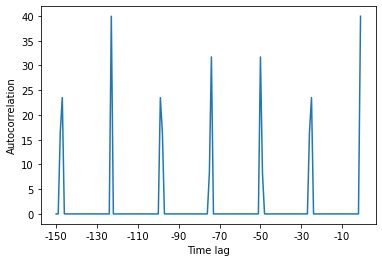

In [13]:
max_lag = 150
I_above_auto_corr = data_analysis.get_autocorrelation(I_above_spike_train,max_lag)
data_analysis.plot_autocorrelation(I_above_auto_corr, max_lag)

<span style="color:blue">**Question 12**.Define a parametric function that models the input current to a LIF neuron. The input current can anything you want, for instance, it can be defined by the sum of various functions, in parts, mixtures models, etc. Varying the parameters of this function generate three spike trains with distinct features between them (biological plausible or not). For the three cases you just have to define the function and the arguments.</span>

nr of spikes: 50


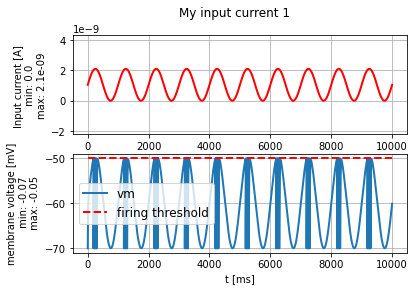

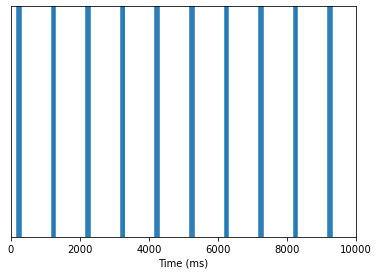

In [14]:
args = {'model_name': 'sin', 't_start': t_start, 't_end': 10000, 'periode': 1000, 'amplitude': 2.1e-09}
#define the arguments here!

my_I_array1 = interface_simulator.make_my_current_array(args) #you should fill this function in interface_simulator
my_I_current1 = io_spike_train.adapt_input(my_I_array1)

(my_I_state_monitor1, my_I_spike_monitor1) = LIF.simulate_LIF_neuron(
        input_current = my_I_current1, simulation_time = t_max_varying_current * b2.ms,v_rest = V_REST*b2.mV,v_reset = V_RESET*b2.mV, firing_threshold = FIRING_THRESHOLD*b2.mV, membrane_resistance = MEMBRANE_RESISTANCE * b2.mohm, membrane_time_scale = MEMBRANE_TIME_SCALE* b2.ms, abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD* b2.ms)

plt.figure()
plot_tools.plot_voltage_and_current_traces(
        my_I_state_monitor1,my_I_current1, title = "My input current 1", firing_threshold = FIRING_THRESHOLD*b2.mV)
print("nr of spikes: {}".format(my_I_spike_monitor1.count[0]))

my_I_spike_train1 = io_spike_train.extract_spike_train_from_spike_monitor(my_I_spike_monitor1,t_max_varying_current) #converts the spikes from brian into a numpy array

data_analysis.plot_spike_train(my_I_spike_train1) #plots the spike train

nr of spikes: 200


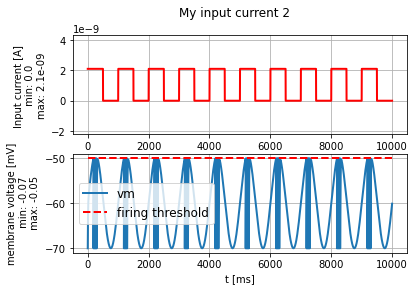

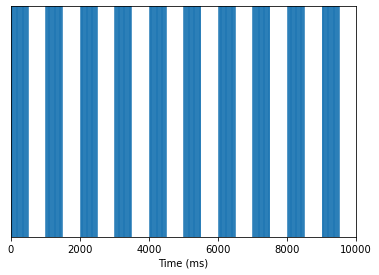

In [15]:
args = {'model_name': 'uniform', 't_start': t_start, 't_end': 10000, 'periode': 1000, 'amplitude': 2.1e-09}
#define the arguments here!

my_I_array2 = interface_simulator.make_my_current_array(args) #you should fill this function in interface_simulator
my_I_current2 = io_spike_train.adapt_input(my_I_array2)

(my_I_state_monitor2, my_I_spike_monitor2) = LIF.simulate_LIF_neuron(
        input_current = my_I_current2, simulation_time = t_max_varying_current * b2.ms,v_rest = V_REST*b2.mV,v_reset = V_RESET*b2.mV, firing_threshold = FIRING_THRESHOLD*b2.mV, membrane_resistance = MEMBRANE_RESISTANCE * b2.mohm, membrane_time_scale = MEMBRANE_TIME_SCALE* b2.ms, abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD* b2.ms)

plt.figure()
plot_tools.plot_voltage_and_current_traces(
        my_I_state_monitor1,my_I_current2, title = "My input current 2", firing_threshold = FIRING_THRESHOLD*b2.mV)
print("nr of spikes: {}".format(my_I_spike_monitor2.count[0]))

my_I_spike_train2 = io_spike_train.extract_spike_train_from_spike_monitor(my_I_spike_monitor2,t_max_varying_current) #converts the spikes from brian into a numpy array

data_analysis.plot_spike_train(my_I_spike_train2) #plots the spike train

nr of spikes: 29


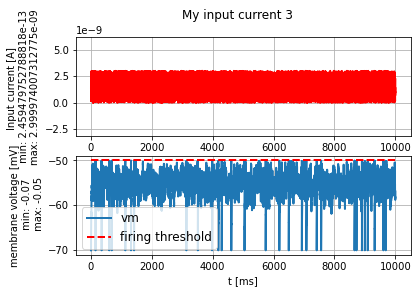

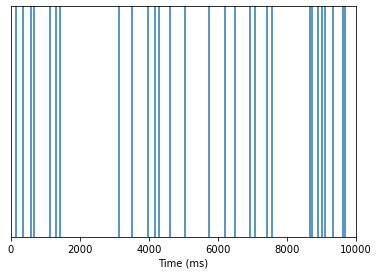

In [16]:
args = {'model_name': 'random', 't_start': t_start, 't_end': 10000, 'amplitude': 3e-09}
#define the arguments here!

my_I_array3 = interface_simulator.make_my_current_array(args) #you should fill this function in interface_simulator
my_I_current3 = io_spike_train.adapt_input(my_I_array3)

(my_I_state_monitor3, my_I_spike_monitor3) = LIF.simulate_LIF_neuron(
        input_current = my_I_current3, simulation_time = t_max_varying_current * b2.ms,v_rest = V_REST*b2.mV,v_reset = V_RESET*b2.mV, firing_threshold = FIRING_THRESHOLD*b2.mV, membrane_resistance = MEMBRANE_RESISTANCE * b2.mohm, membrane_time_scale = MEMBRANE_TIME_SCALE* b2.ms, abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD* b2.ms)

plt.figure()
plot_tools.plot_voltage_and_current_traces(
        my_I_state_monitor3,my_I_current3, title = "My input current 3", firing_threshold = FIRING_THRESHOLD*b2.mV)
print("nr of spikes: {}".format(my_I_spike_monitor3.count[0]))

my_I_spike_train3 = io_spike_train.extract_spike_train_from_spike_monitor(my_I_spike_monitor3,t_max_varying_current) #converts the spikes from brian into a numpy array

data_analysis.plot_spike_train(my_I_spike_train3) #plots the spike train

## Part III: interface_simulator

<span style="color:blue">**Question 13.**Using the functions implemented in part I, compare the temporal sparseness and the bursting of the experimental and simulated spike trains. If necessary, you can implement some auxiliary functions, including plotting functions. This comparison should include some text, figures and tables.</span> 

A13: For the simulated spike trains ('module_name' == 'sin'), we get the following results:

| periode  | amplitude  | nr of spikes | burst_interval |
| :----: | :----: | :----: | :----: |
| 1000 | 2.1e-09 | 50 | [100, 350], [1100, 1350], [2100, 2350], [3100, 3350], [4100, 4350], [5100, 5350], [6100, 6350], [7100, 7350], [8100, 8350], [9100, 9350] |
| 1000 | 2.2e-09 | 90 | [100, 400], [1100, 1400], [2100, 2400], [3100, 3400], [4100, 4400], [5100, 5400], [6100, 6400], [7100, 7400], [8100, 8400], [9100, 9400] |
| 1000 | 2.3e-09 | 120 | [50, 400], [1050, 1400], [2050, 2400], [3050, 3400], [4050, 4400], [5050, 5400], [6050, 6400], [7050, 7400], [8050, 8400], [9050, 9400] |
| 1000 | 2.4e-09 | 150 | [50, 450], [1050, 1450], [2050, 2450], [3050, 3450], [4050, 4450], [5050, 5450], [6050, 6450], [7050, 7450], [8050, 8450], [9050, 9450] |
| 1000 | 2.5e-09 | 190 | [50, 450], [1050, 1450], [2050, 2450], [3050, 3450], [4050, 4450], [5050, 5450], [6050, 6450], [7050, 7450], [8050, 8450], [9050, 9450] |

It can be seen from the above table that for a sine wave, keeping the period constant, as the amplitude increases, the number of spikes continues to increase, and the active burst interval continues to widen.

| periode  | amplitude  | nr of spikes | burst_interval |
| :----: | :----: | :----: | :----: |
| 1000 | 2.1e-09 | 50 | [100, 350], [1100, 1350], [2100, 2350], [3100, 3350], [4100, 4350], [5100, 5350], [6100, 6350], [7100, 7350], [8100, 8350], [9100, 9350] |
| 990 | 2.1e-09 | 50 | [100, 350], [1100, 1350], [2100, 2350], [3100, 3350], [4050, 4350], [5050, 5300], [6050, 6300], [7050, 7300], [8050, 8300], [9000, 9300] |
| 980 | 2.1e-09 | 51 | [100, 350], [1100, 1350], [2050, 2350], [3050, 3300], [4050, 4300], [5000, 5250], [6000, 6250], [6950, 7250], [7950, 8200], [8950, 9200], [9900, 10000] |
| 970 | 2.1e-09 | 55 |[100, 350], [1100, 1350], [2050, 2300], [3000, 3250], [4000, 4250], [4950, 5200], [5950, 6200], [6900, 7150], [7850, 8100], [8850, 9100], [9800, 10000] |
| 960 | 2.1e-09 | 55 | [100, 350], [1050, 1300], [2050, 2300], [3000, 3250], [3950, 4200], [4900, 5150], [5850, 6100], [6850, 7100], [7800, 8050], [8750, 9000], [9700, 9950] |
| 890 | 2.1e-09 | 57 | [100, 350], [1000, 1250], [1850, 2150], [2750, 3000], [3650, 3900], [4550, 4800], [5450, 5700], [6300, 6600], [7200, 7450], [8100, 8350], [9000, 9250], [9900, 10000] |
| 880 | 2.1e-09 | 60 | [100, 350], [950, 1250], [1850, 2100], [2750, 3000], [3600, 3850], [4500, 4750], [5350, 5650], [6250, 6500], [7150, 7400], [8000, 8250], [8900, 9150], [9750, 10000] |
| 860 | 2.1e-09 | 48 | [100, 300], [950, 1200], [1800, 2050], [2650, 2900], [3550, 3750], [4400, 4600], [5250, 5500], [6100, 6350], [6950, 7200], [7850, 8050], [8700, 8900], [9550, 9800] |
| 850 | 2.1e-09 | 48 | [100, 300], [950, 1150], [1800, 2000], [2650, 2850], [3500, 3700], [4350, 4550], [5200, 5400], [6050, 6250], [6900, 7100], [7750, 7950], [8600, 8800], [9450, 9650] |

It can be seen from the above table that for a sine wave, keeping the amplitude constant, as the period decreases, the number of spikes first increases and then decreases, and the active burst interval is constantly narrowing, but the number will increase. This is mainly because as the frequency increases, the current sustaining phase that can produce a spike in each cycle becomes shorter, but the same total time can appear more cycles, so there will be a phenomenon that the first increase will decrease.

Of course, we know that the current with obvious regularity (with a fixed period and fixed amplitude) such as a sine wave is not biological plausible. On the contrary, it is more in line with our common sense for random situations('module_name' == 'sin').

| amplitude  | nr of spikes | burst_interval |
| :----: | :----: | :----: |
| 2.7e-09 | 0 | [] |
| 2.8e-09 | 2 | [] |
| 2.9e-09 | 9 | [1250, 2000] |
| 3e-09 | 40 | [750, 1500], [1750, 2750], [3750, 4750], [5500, 9500] |


According to the above table, we can intuitively see that as the amplitude increases, the number of spikes increases, and the number of active burst interval increases.